# Milestone Project: SklimLit 📑🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 22.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# start our experiments using 20k dataset with umbers replaced by @
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [ ]:
# Check all of the filenames in target directory
import os
filenames=[data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess the data:

In [ ]:
# Create fucntion to read the lines of a document
def get_lines(filename):
  """
  Reads filename(a txt) and returns the lines of text as a list

  """
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
# Lets read in the training lines
train_lines=get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

Lets think about how we want our data to look:

Our data would be best represented if we make list of dictionary:

```

[{'line_number':0,
  'target':'Background',
  'text':'Some text written here',
  'total_lines':No. of lines},
  ...]

```  

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 740 ms, sys: 140 ms, total: 880 ms
Wall time: 2.02 s


(180040, 30212, 30135)

In [ ]:
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Lets now put this into DataFrame

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#Checking the distribution
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

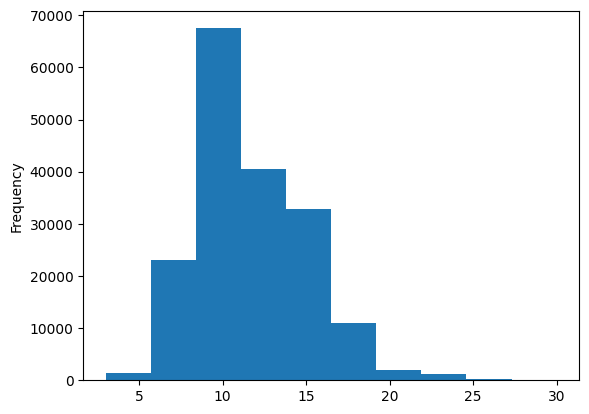

In [ ]:
# Lets check the length of different lines
train_df["total_lines"].plot.hist()

## Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences=train_df["text"].to_list()
val_sentences=val_df["text"].to_list()
test_sentences=test_df["text"].to_list()

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

### One-hot-encoder

In [ ]:
one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### LabelEncoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get the class names and number of classes from LabelEncoder instances
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_

num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline MultinomialNB

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0=Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences,
              val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Getting helper_function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-04-17 01:27:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-04-17 01:27:11 (18.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Prepraing our data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization,Embedding

In [ ]:
# How long is each sentence on average?
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

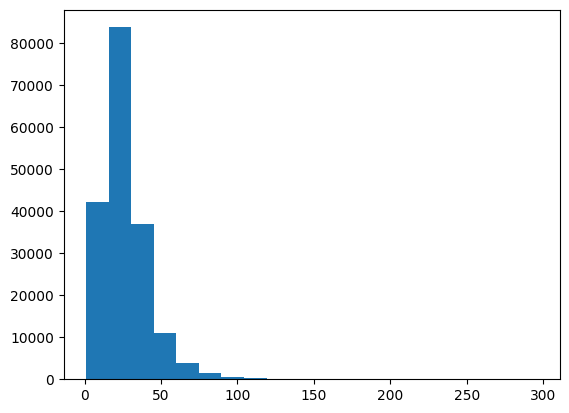

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

In [ ]:
min(sent_lens)

1

### Text vectorizer

We want a layer which converts words to numbers.

In [ ]:
# How many words in vocab?
max_tokens=68000

In [ ]:
text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentences=random.choice(train_sentences)
print(f"Text:\n{target_sentences}")
print(f"\nLength of text: {len(target_sentences)}")
print(f"\nVectorized text: {text_vectorizer([target_sentences])}")


Text:
in addition , many important lessons have been learned in preparation for this study .

Length of text: 86

Vectorized text: [[   5  333  861  430 5004   99  167 5430    5 1406   11   23   17    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocab
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab)

64841

In [ ]:
rct_20k_text_vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [ ]:
rct_20k_text_vocab[-10:]

['aarm',
 'aaqol',
 'aaq',
 'aanhui',
 'aana',
 'aainduced',
 'aaigroup',
 'aachener',
 'aachen',
 'aaacp']

In [ ]:
# Get teh config of our text vectroizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Embedding layer

In [ ]:
token_embed=Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                      output_dim=128,
                      mask_zero=True, # use masking to handle variable sequnece lenght (save space)
                      name="token_embedding")


In [ ]:
print(f"Sentence before converting to numbers:\n {target_sentences}\n")
vectorized_sentences=text_vectorizer([target_sentences])
print(f"Sentence after vectorization:\n {vectorized_sentences}\n")
embedded_sentence=token_embed(vectorized_sentences)
print(f"Sentence after embedding:\n {embedded_sentence}\n")

Sentence before converting to numbers:
 in addition , many important lessons have been learned in preparation for this study .

Sentence after vectorization:
 [[   5  333  861  430 5004   99  167 5430    5 1406   11   23   17    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02752713  0.04501809  0.03162538 ...  0.01486024 -0.00798128
    0.04631091]
  [-0.01939155 -0.01011634 -0.0312471  ...  0.04745651  0.03339937
   -0.03068348]
  [ 0.02041066  0.02322469 -0.0450841  ...  0.02437545  0.02011899
    0.03277213]
  ...
  [-0.0114711  -0.03750401  0.00906087 ...  0.0334821   0.01267088
    0.04688943]
  [-0.0114711  -0.03750401  0.00906087 ...  0.0334821   0.01267088
    0.04688943]
  [-0.0114711  -0.03750401  0.00906087 ...  0.0334821   0.01267088
    0.04688943]]]



## Loading dataset with Tensorflow tf.dataAPI

In [ ]:
# Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the tensorslicedataset and turn them into prefetched datasets

train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequence
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embedding=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embedding)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit the model
history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 22s 33ms/step - loss: 0.9258 - accuracy: 0.6341 - val_loss: 0.6873 - val_accuracy: 0.7404
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6539 - accuracy: 0.7583 - val_loss: 0.6251 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6144 - accuracy: 0.7748 - val_loss: 0.5952 - val_accuracy: 0.7859


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5959 - accuracy: 0.7867


[0.5959014892578125, 0.7866741418838501]

In [ ]:
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.3520117e-01, 1.4459983e-01, 6.8458997e-02, 3.3231053e-01,
        1.9429497e-02],
       [4.6016210e-01, 2.5934729e-01, 1.3985404e-02, 2.5673813e-01,
        9.7670499e-03],
       [1.4774355e-01, 3.6050428e-03, 1.4855601e-03, 8.4711134e-01,
        5.4564309e-05],
       ...,
       [3.8091846e-06, 5.8312382e-04, 5.1716133e-04, 4.7661924e-06,
        9.9889117e-01],
       [5.7394568e-02, 4.9017408e-01, 1.0196859e-01, 5.7086702e-02,
        2.9337609e-01],
       [1.5785389e-01, 6.9768560e-01, 6.4002842e-02, 3.8941961e-02,
        4.1515656e-02]], dtype=float32)

In [ ]:
model_1_pred_probs.shape

(30212, 5)

In [ ]:
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
model_1_results=calculate_results(val_labels_encoded,
                                  model_1_preds)
model_1_results

{'accuracy': 78.66741692042896,
 'precision': 0.7836302260650064,
 'recall': 0.7866741692042897,
 'f1': 0.7843659774851068}

## Model 2:Feature extractor with pretrained token embeddings

Using universal-sentence-encoder

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


In [ ]:
#test out use
random_train_sentence=random.choice(train_sentences)
print(f"Random sentence: \n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence}")

Random sentence: 
 this was a double-blind , randomized , placebo-controlled , @-way crossover study to determine the reversal effect of descending doses of @f-pcc on bleeding duration and bleeding volume following edoxaban treatment .
Sentence after embedding:
 [[ 1.90036036e-02  2.88458187e-02  4.66475226e-02 -3.95704694e-02
  -7.05721527e-02 -6.46950454e-02  7.17082843e-02 -5.83951250e-02
   4.12575863e-02  7.90637657e-02  8.48203823e-02  1.72452070e-02
   2.75196880e-02  3.21982168e-02 -2.16770060e-02 -2.02346276e-02
  -7.82589838e-02 -5.41894957e-02 -6.29519075e-02 -2.84276363e-02
  -3.78007293e-02  8.23341757e-02 -6.59575760e-02 -3.64682935e-02
  -1.66527741e-02  2.95940088e-04 -8.41516303e-04 -1.07496895e-03
  -2.58774944e-02 -5.97919710e-02 -3.16800028e-02  8.35903138e-02
   3.77840512e-02  5.18079475e-02 -7.42576197e-02  6.72798790e-03
  -5.90708405e-02  4.21266295e-02 -6.31747246e-02 -4.13072892e-02
   3.96045819e-02  6.47243261e-02 -2.01679897e-02 -6.99337572e-02
  -2.961929

In [ ]:
inputs=layers.Input(shape=[],dtype="string")
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize text + create embedding
x=layers.Dense(128,activation="relu")(pretrained_embedding)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_use")

In [ ]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9169 - accuracy: 0.6487 - val_loss: 0.7964 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7677 - accuracy: 0.7028 - val_loss: 0.7551 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7506 - accuracy: 0.7133 - val_loss: 0.7381 - val_accuracy: 0.7128


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7390 - accuracy: 0.7135


[0.7389547824859619, 0.7135244011878967]

In [ ]:
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred=model_2_pred_probs.argmax(axis=1)
model_2_pred

945/945 [==============================] - 10s 10ms/step


array([0, 1, 3, ..., 4, 4, 2])

In [ ]:
model_2_results=calculate_results(val_labels_encoded,
                                  model_2_pred)
model_2_results

{'accuracy': 71.35244273798492,
 'precision': 0.7135239264281968,
 'recall': 0.7135244273798491,
 'f1': 0.7105446118604285}

## Model 3: Conv1D using character embedding

what is difference betweeen character & token used previously?

Assume a sentence "I love TensorFlow" in token used previously each word gets turned into a feature vector.

But if we use character-level embedding then each character gets turned into a feature vector.

### Creating a character -level tokenizer

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

't h i s   w a s   a   d o u b l e - b l i n d   ,   r a n d o m i z e d   ,   p l a c e b o - c o n t r o l l e d   ,   @ - w a y   c r o s s o v e r   s t u d y   t o   d e t e r m i n e   t h e   r e v e r s a l   e f f e c t   o f   d e s c e n d i n g   d o s e s   o f   @ f - p c c   o n   b l e e d i n g   d u r a t i o n   a n d   b l e e d i n g   v o l u m e   f o l l o w i n g   e d o x a b a n   t r e a t m e n t   .'

In [ ]:
# split sequence-level data splits into character-level splits
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Whats the average character length?
char_lens=[len(sentences) for sentences in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

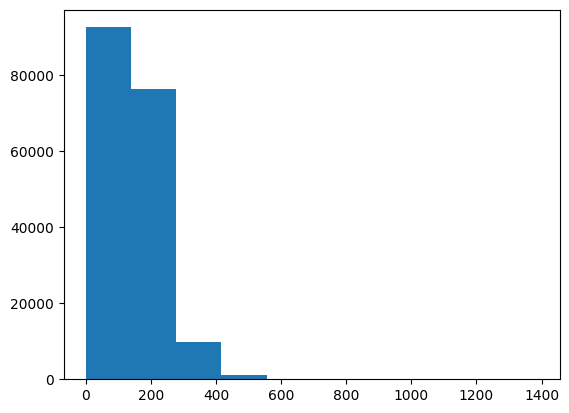

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=10);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
import string
alphabet=string.ascii_lowercase + string.digits + string.punctuation
len(alphabet),alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [ ]:
# Char-level token vectorizer instance
NUM_CHAR_TOKENS= len(alphabet) + 2 # (space & out of vocabulary)
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name="char_vectorizer")

In [ ]:
# Adapting
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab=char_vectorizer.get_vocabulary()

In [ ]:
len(char_vocab)

28

In [ ]:
char_vocab[:10]

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']

In [ ]:
char_vocab[-10:]

['g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']

In [ ]:
random_train_chrs=random.choice(train_chars)
print(f"Charified text: \n {random_train_chrs}")
print(f"Length of random train_chrs {len(random_train_chrs.split())}")
vectorized_chars=char_vectorizer([random_train_chrs])
print(f"\n Vectorized chars:\n {vectorized_chars}")
print(f"\n length of vectorized chars: {len(vectorized_chars[0])}")


Charified text: 
 t r a i n e e s   '   p e r f o r m a n c e s   w e r e   v i d e o t a p e d   a n d   a s s e s s e d   b y   t w o   e x p e r t   r a t e r s   u s i n g   a   c h e c k l i s t   t h a t   i n c l u d e d   a   g l o b a l   r a t i n g   .
Length of random train_chrs 104

 Vectorized chars:
 [[ 3  8  5  4  6  2  2  9 14  2  8 17  7  8 15  5  6 11  2  9 20  2  8  2
  21  4 10  2  7  3  5 14  2 10  5  6 10  5  9  9  2  9  9  2 10 22 19  3
  20  7  2 24 14  2  8  3  8  5  3  2  8  9 16  9  4  6 18  5 11 13  2 11
  23 12  4  9  3  3 13  5  3  4  6 11 12 16 10  2 10  5 18 12  7 22  5 12
   8  5  3  4  6 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

### Creating a character-level Embedding

In [ ]:
char_embed=Embedding(input_dim=len(char_vocab),
                     output_dim=25,
                     mask_zero=False,
                     name="char_embed")

In [ ]:
print(f"Charified text:\n {random_train_chrs}\n")
char_embed_example=char_embed(char_vectorizer([random_train_chrs]))
print(f"Embedded Chars: {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t r a i n e e s   '   p e r f o r m a n c e s   w e r e   v i d e o t a p e d   a n d   a s s e s s e d   b y   t w o   e x p e r t   r a t e r s   u s i n g   a   c h e c k l i s t   t h a t   i n c l u d e d   a   g l o b a l   r a t i n g   .

Embedded Chars: [[[-0.00768584 -0.04610801  0.04846833 ...  0.00389748 -0.0072909
   -0.01088288]
  [ 0.00397861  0.02882281  0.04726266 ... -0.01085471 -0.03192352
   -0.04209614]
  [ 0.03549347  0.02042637 -0.03524752 ...  0.02662054  0.00335708
    0.01719023]
  ...
  [-0.03164887 -0.03522184 -0.0156785  ... -0.00325497 -0.04262635
   -0.03259934]
  [-0.03164887 -0.03522184 -0.0156785  ... -0.00325497 -0.04262635
   -0.03259934]
  [-0.03164887 -0.03522184 -0.0156785  ... -0.00325497 -0.04262635
   -0.03259934]]]
Character embedding shape: (1, 290, 25)


## Model 3: Conv1D with character level embeddings

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="Model_3")

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
# Converting our datasets into char level datasets
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2888 - accuracy: 0.4774 - val_loss: 1.1121 - val_accuracy: 0.5472
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.0593 - accuracy: 0.5738 - val_loss: 0.9854 - val_accuracy: 0.6097
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9723 - accuracy: 0.6150 - val_loss: 0.9251 - val_accuracy: 0.6320


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.9402 - accuracy: 0.6318


[0.940155029296875, 0.6317688226699829]

In [ ]:
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred=tf.argmax(model_3_pred_probs,axis=1)
model_3_pred[:10]

945/945 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 2, 2, 2, 2, 3, 4, 1])>

In [ ]:
model_3_results=calculate_results(val_labels_encoded,
                                  model_3_pred)
model_3_results

{'accuracy': 63.17688335760625,
 'precision': 0.6374840511990176,
 'recall': 0.6317688335760625,
 'f1': 0.6133166609210733}

## Model 4: Combining pretrained token embeddings + Characters embeddings(hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs=layers.Input(shape=[],dtype="string",name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,
                           token_output)

#2. Setup charc inputs/model
char_inputs=layers.Input(shape=(1,),dtype="string",name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

#3. Concatenate token and char inputs
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])
#4. Create output layers-adding Dropout
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

#5. Construct model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="Model_4_token_and_char_embeddings")


In [ ]:
model_4.summary()

Model: "Model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

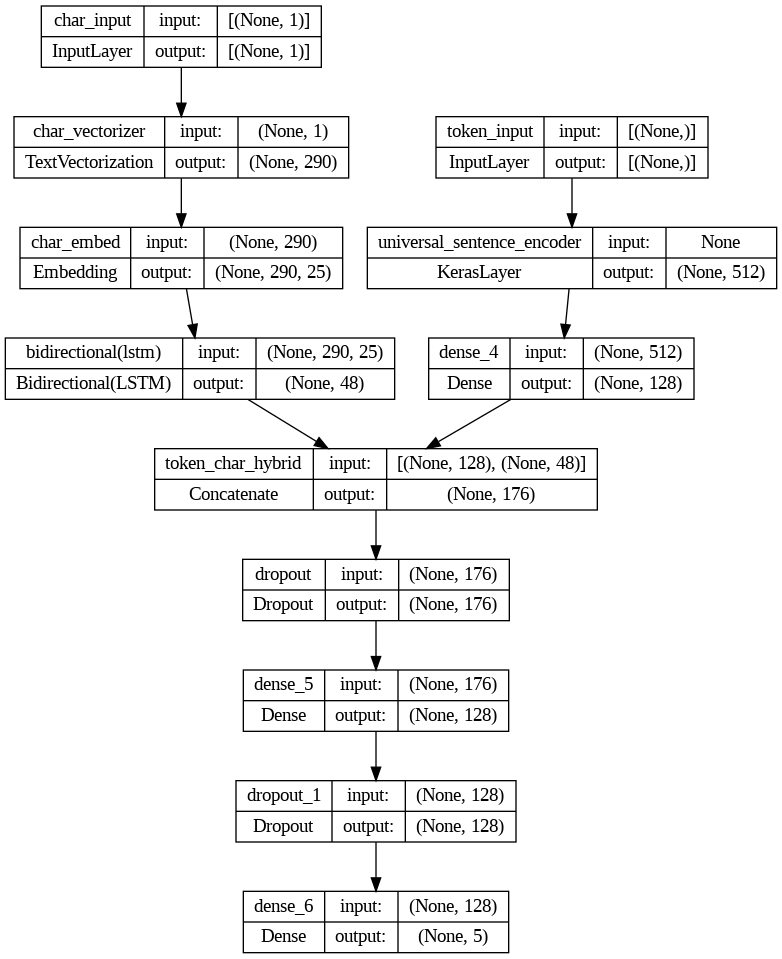

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=["accuracy"])

### Combining token and char data into tf.data.Dataset

In [ ]:
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # Make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # Make labels
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset,val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 26s 35ms/step - loss: 0.9914 - accuracy: 0.6065 - val_loss: 0.7885 - val_accuracy: 0.6941
Epoch 2/3
562/562 [==============================] - 20s 35ms/step - loss: 0.8192 - accuracy: 0.6863 - val_loss: 0.7326 - val_accuracy: 0.7227
Epoch 3/3
562/562 [==============================] - 18s 31ms/step - loss: 0.7868 - accuracy: 0.7012 - val_loss: 0.7012 - val_accuracy: 0.7357


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7065 - accuracy: 0.7304


[0.7064801454544067, 0.7303720116615295]

In [ ]:
model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs[:2]

945/945 [==============================] - 17s 17ms/step


array([[0.43086627, 0.39984822, 0.00504206, 0.15708303, 0.00716047],
       [0.3515488 , 0.46052206, 0.00392822, 0.18102686, 0.00297407]],
      dtype=float32)

In [ ]:
model_4_pred=tf.argmax(model_4_pred_probs,axis=1)
model_4_pred[:2]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>

In [ ]:
model_4_results=calculate_results(val_labels_encoded,
                                  model_4_pred)

In [ ]:
model_4_results

{'accuracy': 73.03720376009532,
 'precision': 0.7303548700797016,
 'recall': 0.7303720376009533,
 'f1': 0.7264291247112374}

## Model 5: Transfer Learning with pretrained token embedding + character embedding + positional embedding

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


### Creating positional embedding

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

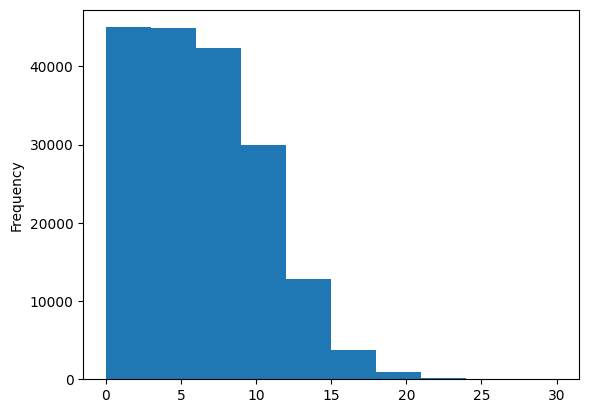

In [ ]:
# Check the distribution of line_number
train_df["line_number"].plot(kind="hist");

**🗒️ Note: why we used 15 as depth instead of 30?**

This we did as total numbers of sample after 15 are very less and we don't want to get curse of dimensionality.

In [ ]:
# Useing One-hot encoder
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

In [ ]:
train_df["total_lines"].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

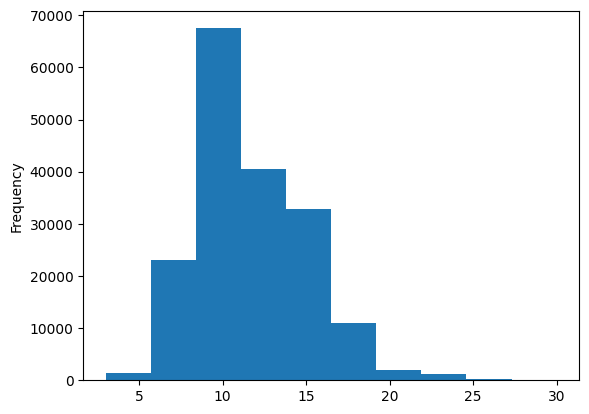

In [ ]:
train_df["total_lines"].plot(kind="hist");

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df["total_lines"],98)

20.0

In [ ]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [ ]:
#1. Token Inputs
token_inputs=layers.Input(shape=[],dtype="string",name="token_inputs")
token_embedding=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embedding)
token_model=tf.keras.Model(token_inputs,token_outputs)

#2. Char inputs
char_inputs=layers.Input(shape=(1,),dtype="string",name="Char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embedding=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

#3. Line_number feature
line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,x)

#4. Total_line_feature
total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_line_input")
y=layers.Dense(32,activation="relu")(total_line_inputs)
total_lines_model=tf.keras.Model(total_line_inputs,
                                y)

#5. Concatenate
combined_embeddings=layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

#6. Combine positional with above layer
tribrid_embedding=layers.Concatenate(name="char_toke_embedding_embedding")([line_number_model.output,total_lines_model.output,z])


#7. Create output layer
output_layer=layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embedding)

#8. Put together model with all kinds of inputs
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer)

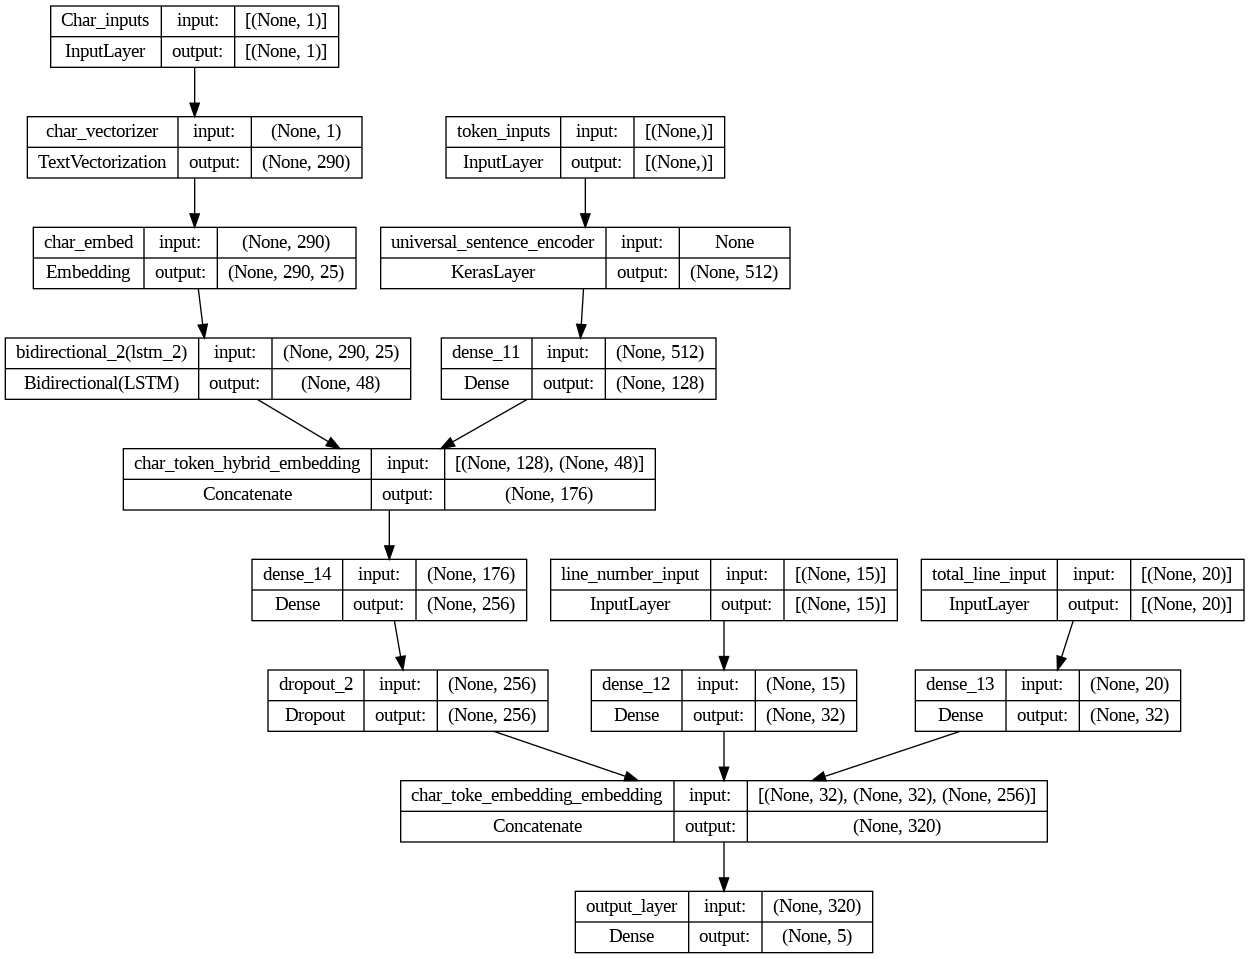

In [ ]:
plot_model(model_5,show_shapes=True)

### what is Label smoothing?

For example , if our model gets too confident on single class(e.g its prediction probablity is really high), it may get struck on that class and not consider other classes....

It actually helps to prevent overfitting.

It does is assign some of value from highest pred prob to other classes, in turn, hopefully improving.

In [ ]:
# Compile token,char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["Accuracy"])

In [ ]:
# Create training and validation datasets
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                             train_total_lines_one_hot,
                                                             train_sentences,
                                                             train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5=model_5.fit(train_char_token_pos_dataset,
                            steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                            epochs=3,
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1 * len(val_char_token_pos_dataset)))


Epoch 1/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9439 - Accuracy: 0.8312 - val_loss: 0.9326 - val_Accuracy: 0.8358
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9257 - Accuracy: 0.8431 - val_loss: 0.9256 - val_Accuracy: 0.8441
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9203 - Accuracy: 0.8461 - val_loss: 0.9248 - val_Accuracy: 0.8364


In [ ]:
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset,verbose=0)
model_5_pred_probs

array([[0.52124405, 0.08462857, 0.01034884, 0.36715844, 0.01662014],
       [0.5146434 , 0.10095328, 0.0569969 , 0.31542155, 0.01198489],
       [0.30885705, 0.09856018, 0.07128521, 0.459904  , 0.06139361],
       ...,
       [0.0318438 , 0.12534215, 0.04207476, 0.03066078, 0.7700785 ],
       [0.02774235, 0.33340338, 0.07195957, 0.02288527, 0.54400945],
       [0.13759552, 0.7409227 , 0.03930048, 0.03986618, 0.04231524]],
      dtype=float32)

In [ ]:
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results=calculate_results(val_labels_encoded,
                                  model_5_preds)
model_5_results

{'accuracy': 84.27446047927975,
 'precision': 0.8423055000539565,
 'recall': 0.8427446047927976,
 'f1': 0.8415665051934429}

## Comapre model Results

In [ ]:
all_models_results=pd.DataFrame({"model_0_baseline":baseline_results,
                                 "model_1_custom_token_embedding":model_1_results,
                                 "model_2_pretrained_token_embedding":model_2_results,
                                 "model_3_custom_char_embedding":model_3_results,
                                 "model_4_hybrid_char_token_embedding":model_4_results,
                                 "model_5_pos_char_token_embedding":model_5_results})
all_models_results

,model_0_baseline,model_1_custom_token_embedding,model_2_pretrained_token_embedding,model_3_custom_char_embedding,model_4_hybrid_char_token_embedding,model_5_pos_char_token_embedding
accuracy,72.183238,78.667417,71.352443,63.176883,73.037204,84.274460
precision,0.718647,0.783630,0.713524,0.637484,0.730355,0.842306
recall,0.721832,0.786674,0.713524,0.631769,0.730372,0.842745
f1,0.698925,0.784366,0.710545,0.613317,0.726429,0.841567


In [ ]:
all_models_results=all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.667417,0.783630,0.786674,0.784366
model_2_pretrained_token_embedding,71.352443,0.713524,0.713524,0.710545
model_3_custom_char_embedding,63.176883,0.637484,0.631769,0.613317
model_4_hybrid_char_token_embedding,73.037204,0.730355,0.730372,0.726429
model_5_pos_char_token_embedding,84.274460,0.842306,0.842745,0.841567


In [ ]:
all_models_results["accuracy"]=all_models_results["accuracy"]/100

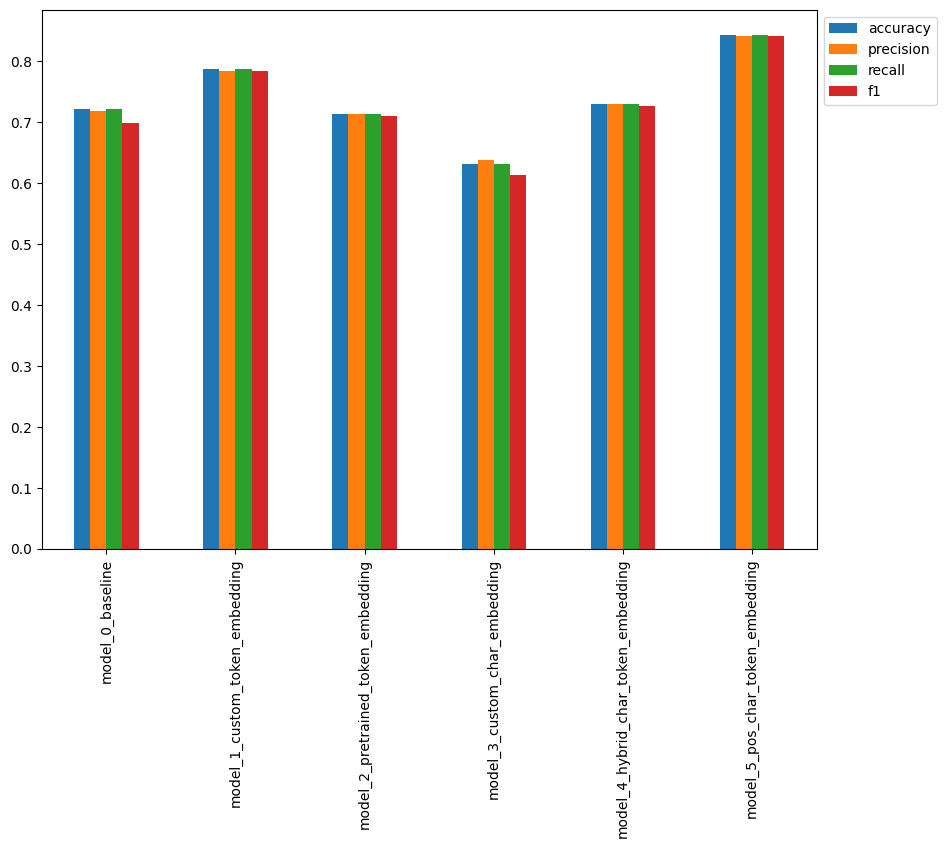

In [ ]:
all_models_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))


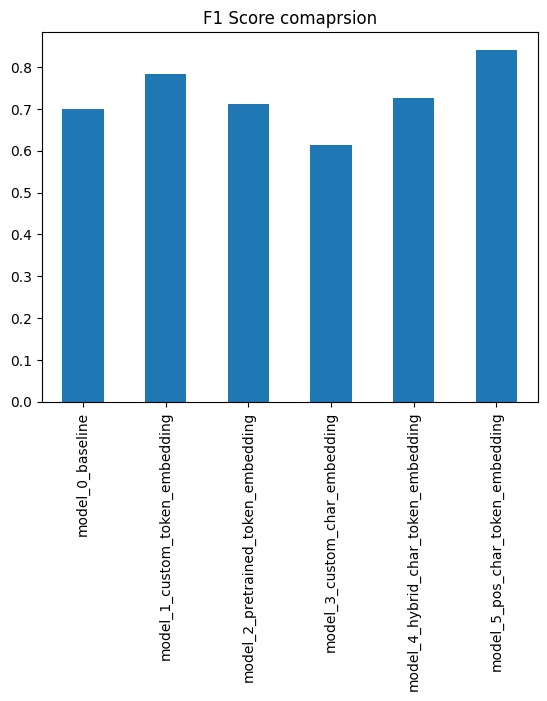

In [ ]:
all_models_results["f1"].plot(kind="bar")
plt.title("F1 Score comaprsion");

## Save and Load Model

In [ ]:
model_5.save("Skimlit_tribrid_model")

In [ ]:
loaded_model=tf.keras.models.load_model("Skimlit_tribrid_model")


In [ ]:
loaded_model_preds=tf.argmax(loaded_model.predict(val_char_token_pos_dataset),axis=1)
loaded_model_preds

945/945 [==============================] - 23s 24ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
loaded_models_results=calculate_results(val_labels_encoded,
                                        loaded_model_preds
                                        )
loaded_models_results

{'accuracy': 84.27446047927975,
 'precision': 0.8423055000539565,
 'recall': 0.8427446047927976,
 'f1': 0.8415665051934429}